In [116]:
%%latex

$$\textbf{A brief summary of what has been done}$$
$$\\$$

$\mathbf{1.}$ In the beginning we construct ISM transmition function which depends on $z$ and $\lambda$ (not redshifted).
In the code below it is named $$\textit{F_IMS}$$

$$\\$$

$\mathbf{2.}$ In the next cell we choose a filter to work with (in our case it is f160w) and build its 
transmition function $$\textit{F_filter}$$

$$\\$$

$\mathbf{3.}$ Inside the following cell we face for the first time the source data for the fake hst image simulation and 
thereafter extract and derived from it another important quantities such as masses, times, metallicities and current
redshift. It is worth to mention that we specified a spherical region (25 kpc) with the highest mass density 
at the center in lieu of working with the full box.

$$\\$$

$\mathbf{4.}$ Next there are two functions for convenience. To understand what they stand for see its description.

$$\\$$

$\mathbf{5.}$ Now we enter the main simulation process. First, let's break down simple but important calculations here:

$$\\$$

5.1 The angular size of our specified region is
\begin{equation}
\theta \thinspace [milli-arcsec] = \frac{2 \times R \thinspace  [kpc]}{D_{a} [Mpc]} \times (radians \thinspace to \thinspace milli-arcsec
                                                                  \thinspace coef)
= \frac{2 \times 25 \thinspace  [pc] \times 10^{3}}{D_{a} [pc] \times 10^{6}} \times 206265 \times 10^{3},
\end{equation}
where $D_{a}$ - angular distance, $2R$ - diameter of the sphere

$$\\$$

5.2 Then we want milli-arcsecond/pixel = 60/1 ratio. Therefore, number of pixels along each axis is simply $nbins = 
\theta \thinspace [milli-arcsec] / 60$

$$\\$$

$\mathbf{6.}$ The next step is to work with fluxes. Let's consider an arbitrary pixel in our mesh. 
$$\\$$

6.1 Initially, from look-up tables
we have SED in [ (Solar luminosity units) / (Solar mass units) / Hz ] for specific time, metallicity and wavelength
$$\\$$
6.2 Then from our source data we know the amount of mass concentrated in the pixel. So we multiply SED by this
amount of mass $m$[in solar mass units].
$$\\$$
6.3 Because these calculations for a specific $\lambda$ and $z$ we can also multiply ($SED \times m$) by transmition 
function throughout the ISM (F_IMS).

6.4 Now we can compute total flux:
\begin{equation}
\mathbf{F} \thinspace \left[ \thinspace \frac{erg}{s \thinspace cm{2}} \thinspace \right]
\thinspace =  \thinspace \frac{ \int\limits_{0}^{+\infty} L_{\nu} \times F_{filter} \times L_{\odot} d\nu}{4\pi D_{L}^{2}}, \quad
\text{where} \thinspace L_{\odot} = 3.828 \times 10^{33}, \thinspace L_{\nu} = SED \times m \times F_{ISM}
\thinspace [\thinspace (Solar  \thinspace luminosity  \thinspace units) \thinspace /  \thinspace Hz \thinspace ]
\end{equation} 
and $D_{L}$ is the luminosity distance [Mpc].

$$\\$$

$\mathbf{7.}$ Finally, only two things left to do. We should add noize to our image and then convolve it with Point 
spread function for f160w filter.

$$\\$$
7.1 We get noise data from another image. Therefore, before adding the noise to our image we need to make sure
that the units of two term in the sum are the same. Actually, it turns out, that there are not. Thus, let's convert 
Flux $\mathbf{F}$.
$$\\$$
Noise data zero point = 25.94. 
$$\\$$
$\mathbf{F}$ in $\thinspace \left[ \thinspace \frac{erg}{s \thinspace cm{2}} \thinspace \right]
$ corresponds to zero point = -48.6.
$$\\$$
\begin{equation}
\kappa \thinspace \thinspace (from \thinspace \mathbf{F} \thinspace to \thinspace noise) \thinspace = \thinspace 10^{0.4(25.94 + 48.6)} = 6.5464 \times 10^{29}
\end{equation}
$$\\$$
\begin{equation}
\mathbf{\tilde{F}} = \mathbf{F} \times \kappa + noise \thinspace \thinspace  data
\end{equation}





<IPython.core.display.Latex object>

In [115]:
%matplotlib notebook

import yt
import glob
import numpy             as np
import cosmolopy         as cp
import matplotlib.pyplot as plt
import matplotlib.cm     as cm
import scipy.ndimage     as ndimage

from scipy               import signal
from scipy.interpolate   import interp1d
from scipy.interpolate   import interp2d
from scipy.interpolate   import RegularGridInterpolator
from scipy               import integrate
from astropy.io          import fits
from astropy             import wcs


<IPython.core.display.Javascript object>


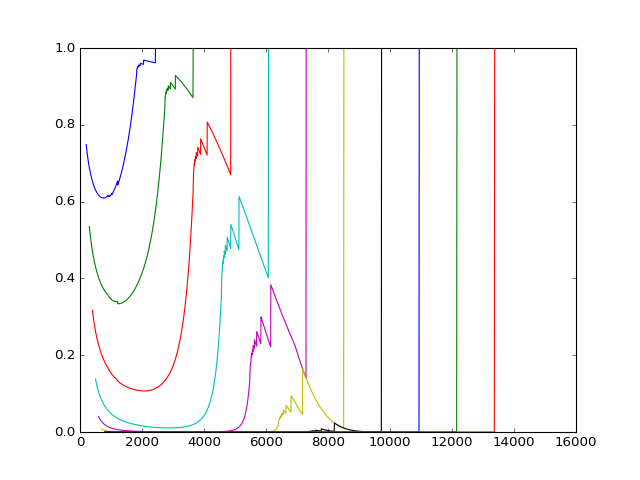

In [80]:
'''

Transmition function throughout the ISM, which depends on redshift z and radiation wavelength

'''

table = np.loadtxt('table_transmition_ISM.dat')
lam_rest   = table[1:,0]
z          = table[0,1:]
trans_coef = table[1:,1:]

F_IMS = interp2d(z, lam_rest, trans_coef)

plt.figure(0)
for i in range(1,11):
    plt.plot(lam_rest*(1+i),F_IMS(i,lam_rest))

    

In [81]:
'''

To get the filter of interest (f160w), its transmition function, the lowest and the highest wavelength

'''

filters_info = []
for line in open('data/FILTER.RES.latest.info', 'r'):
    filters_info.append(np.array(line.split()))
filters_info = np.array(filters_info)

temp_filters = open('data/FILTER.RES.latest', 'r')
filters = []
filters_names = []
first = True

for line in temp_filters:

    if line[0] == ' ':
        if not first:
            filters.append(np.array(temp))

        first = False
        filters_names.append(line.split())
        temp = []

    else:
        temp.append(np.array(line.split()).astype('float'))

filters.append(np.array(temp))
filters = np.array(filters)

for ifilt in range(len(filters_names)):
    if filters_names[ifilt][1] == 'hst/wfc3/IR/f160w.dat':
        filter_b = np.array([filters[ifilt][:,1],filters[ifilt][:,2]])
        filter_b = np.transpose(filter_b)

F_filter = interp1d(filter_b[:,0], filter_b[:,1],fill_value=0.0)
left,right = np.min(filter_b[:,0]),np.max(filter_b[:,0])

yt : [INFO     ] 2016-08-13 18:33:51,839 Created 7 chunks for ARTIO


<IPython.core.display.Javascript object>


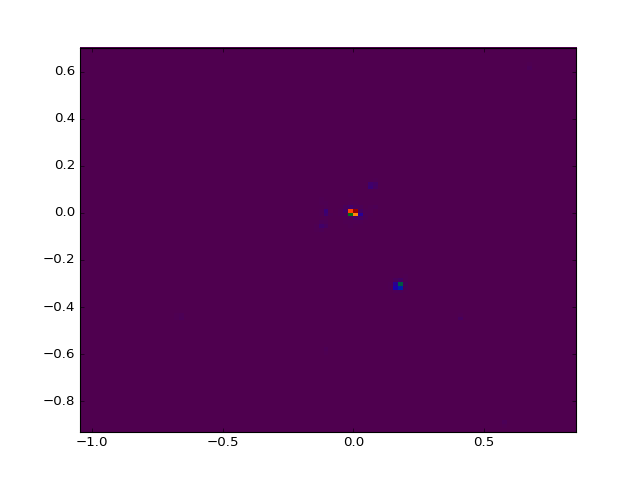

(array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 array([-1.04655808, -1.02756242, -1.00856676, -0.9895711 , -0.97057544,
        -0.95157978, -0.93258412, -0.91358845, -0.89459279, -0.87559713,
        -0.85660147, -0.83760581, -0.81861015, -0.79961449, -0.78061883,
        -0.76162316, -0.7426275 , -0.72363184, -0.70463618, -0.68564052,
        -0.66664486, -0.6476492 , -0.62865354, -0.60965787, -0.59066221,
        -0.57166655, -0.55267089, -0.53367523, -0.51467957, -0.49568391,
        -0.47668825, -0.45769258, -0.43869692, -0.41970126, -0.4007056 ,
        -0.38170994, -0.36271428, -0.34371862, -0.32472296, -0.30572729,
        -0.28673163, -0.26773597, -0.24874031, -0.22974465, -0.21074899,
        -0.19175333, -0.17275767, -0.153762  , -0.1347663

In [82]:
'''

To load and thereafter calculate all the necessary data for simulation

'''

sun_lumi = 3.828e33 # [erg/s]
sun_mass = 1.989e33 # [g]
secinrad = 206265.0

muf_list = glob.glob("./drt/muv.bin*")             # Solar lumi/ Hz / Solar mass (log10 time in yr, metallicity, lambda) tables
files = glob.glob("./rei05B_a0*/rei05B_a*.art")    # 3D HST Data
pf = yt.load(files[0])

lam_list = np.zeros(len(muf_list))
lookup = np.zeros([len(muf_list), 188, 22])

for i in range(len(muf_list)):

    f = open(muf_list[i])
    header = f.readline()
    f.close()
    d1 = header.split()[0]
    d2 = header.split()[1]
    lam_list[i] = float(header.split()[2])

    data = np.genfromtxt(muf_list[i], skip_header=1)
    lookup[i, :, :] = data[1:,1:]

dx = data[0, 1:] # metallicity in Solar metal. units
dy = data[1:, 0] # log10 time in yr

# to specify a region of interest in the sky
data = pf.sphere([1.52643699e+2/7.20807692,  1.08564619e+2/7.20807692,  9.16425327e+1/7.20807692], (25.0, "kpc")) # " 1 ---> 7.20807692e+22 "

x = np.array(data[('STAR', 'POSITION_X')]) - 1.52643699e+2/7.20807692
y = np.array(data[('STAR', 'POSITION_Y')]) - 1.08564619e+2/7.20807692
z = np.array(data[('STAR', 'POSITION_Z')]) - 9.16425327e+1/7.20807692

m = data[('STAR', 'MASS')].in_units('g')/sun_mass
met = data[('STAR', 'METALLICITY_SNIa')] + data[('STAR', 'METALLICITY_SNII')]
t = np.log10(data[('STAR', 'age')].in_units('yr'))
redshift = pf.current_redshift
lam_list *= (1+redshift) # to get redshifted lam

plt.figure(1)
plt.hist2d(x,y,100)

In [88]:
def pixel_integration(pixel,lam):

    '''

     To integrate each pixel over all the lambdas with f160w filter transmition function (F_filter)

     pixel: 3d array, (pixel SED(lambdas) 2d map, lambdas) [x direction, y direction, lambdas],
     units [erg/s/Hz/Solar_luminosity]

     lam: 1d array, containing lambdas to integrate over, redshifted,
     units [angstrom]

     mtr_int: matrix, total flux from the object at redshift z in each pixel,
     units [erg/s/cm^2]

    '''
    
    sun_lumi = 3.828e33
    c = 2.99792458e10
    nu = c/(lam/1e8)

    mtr_int = np.zeros_like(pixel[:,:,0])

    for i in range(0,len(pixel[:,0,0])):
        for j in range(0,len(pixel[0,:,0])):

            mtr_int[i,j] = integrate.trapz( pixel[i,j,::-1] * sun_lumi * F_filter(lam[::-1])  ,nu[::-1]) / (4 * np.pi * np.power(lum_dist*3.0857e18*1e6,2))

    return mtr_int

In [89]:
def filter_range(a,b,x): # x - array, a,b - number (boundaries)
    
    global lambdas

    '''

    Initially we have SED tables for vast range of wavelengths and this function picks out those wavelengths, which
    are in filter range (for our current purposes it is f160w).

    '''

    position_in_lam_array = []
    lambdas               = []

    for i in range(0,len(x)):
        if (a<=x[i] and x[i]<=b):
            
            if(F_filter(x[i]) >= 1e-3):
                
                position_in_lam_array.append(i)
                lambdas.append(x[i])

    lambdas = np.array(lambdas)
    position_in_lam_array = np.array(position_in_lam_array)

    indices = np.argsort(lambdas)

    return position_in_lam_array[indices]

number of pixels 163


<IPython.core.display.Javascript object>


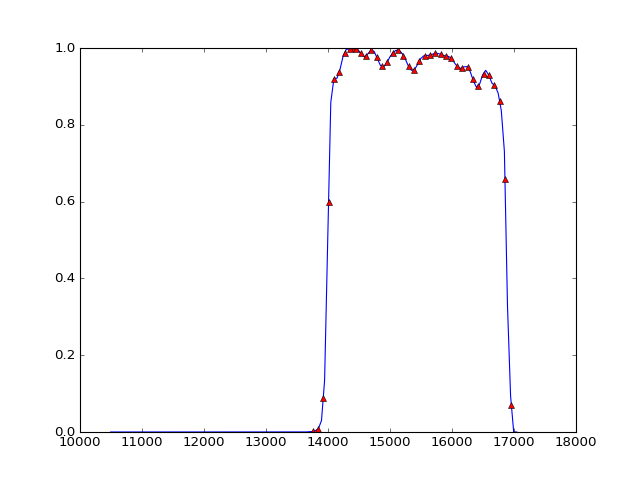

In [90]:
'''

The main procedure to create a fake HST image

nbins: number of pixels in our image (both for x axix and y axix [z axis])

ang_dist: angular distance
units [Mpc]

lum_dist: luminosity distance
units [Mpc]

filter_lam: lambdas, which are in the filter range
units [Angstoms]

theta_milliarcsec: selected region as it is seen by HST
units [milli-arcseconds]

We define the following resolution for the fake image: 60 milli-arcsecond/pixel

'''


ang_dist = cp.distance.angular_diameter_distance(redshift, **cp.fidcosmo)
lum_dist = ang_dist * (1+redshift) * (1+redshift)

theta_milliarcsec = ( 2 * 25.0 * 1e3 ) / ( ang_dist * 1e6  ) * ( secinrad * 1e3 )
nbins =  int(theta_milliarcsec * 1/60)

print('number of pixels', nbins)

filter_lam = filter_range(left,right,lam_list)

plt.figure(2)
plt.plot(filter_b[:,0],F_filter(filter_b[:,0]),'b-')
plt.plot(lambdas,F_filter(lambdas),'r^')




396 13750.4400596 1595.0 1.0
271 13836.6497152 1605.0 1.0
52 13922.8593707 1615.0 1.0
287 14009.0690263 1625.0 1.0
230 14095.2786818 1635.0 1.0
514 14181.4883374 1645.0 1.0
246 14267.6979929 1655.0 1.0
458 14353.9076485 1665.0 1.0
283 14414.2544073 1672.0 1.0
329 14457.3592351 1677.0 1.0
13 14526.3269596 1685.0 1.0
530 14612.5366151 1695.0 1.0
355 14698.7462706 1705.0 1.0
506 14784.9559262 1715.0 1.0
115 14871.1655817 1725.0 1.0
330 14957.3752373 1735.0 1.0
349 15043.5848928 1745.0 1.0
74 15129.7945484 1755.0 1.0
541 15216.0042039 1765.0 1.0
99 15302.2138595 1775.0 1.0
319 15388.423515 1785.0 1.0
297 15474.6331706 1795.0 1.0
384 15560.8428261 1805.0 1.0
312 15647.0524817 1815.0 1.0
526 15733.2621372 1825.0 1.0
505 15819.4717927 1835.0 1.0
188 15905.6814483 1845.0 1.0
325 15991.8911038 1855.0 1.0
550 16078.1007594 1865.0 1.0
104 16164.3104149 1875.0 1.0
463 16250.5200705 1885.0 1.0
328 16336.729726 1895.0 1.0
219 16422.9393816 1905.0 1.0
343 16509.1490371 1915.0 1.0
249 16595.3586927 19

<IPython.core.display.Javascript object>


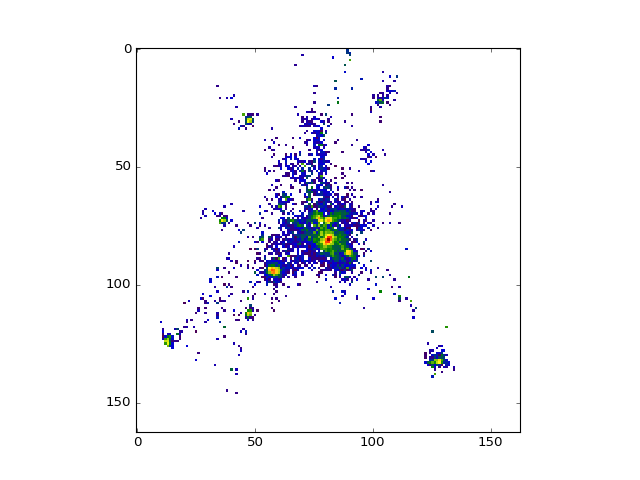

/home/maryhallow/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:27: RuntimeWarning: divide by zero encountered in log10


In [91]:
image = np.zeros([nbins, nbins, 3, len(filter_lam)])
image_int = np.zeros([nbins, nbins, 3, 0])

index = 0

for i in filter_lam:

    print(i,lam_list[i],lam_list[i]/(1+redshift),F_IMS(redshift,lam_list[i]/(1+redshift))[0])

    interp = interp2d(dx, dy, lookup[i, :, :])
    temp = m.copy()

    for j in range(len(m)):
        temp[j] *= F_IMS(redshift,lam_list[i]/(1+redshift))[0]*interp(met[j], t[j])[0]  # [erg/s/Hz] in Solar luminosity

    xedges = np.linspace(-data.radius, data.radius, nbins+1)
    yedges = np.linspace(-data.radius, data.radius, nbins+1)

    H, X, Y = np.histogram2d(x, y, bins=(xedges, yedges), weights = temp)
    image[:, :, 0, index] = H

    index += 1

image_int = pixel_integration(image[:,:,0,:],lam_list[filter_lam])

plt.figure(3)
plt.imshow(np.log10(image_int), interpolation='nearest')

CTYPE1  ='RA---TAN'                                                              [astropy.io.fits.card]
CTYPE2  ='DEC--TAN'                                                              [astropy.io.fits.card]
DATE-OBS='2009-12-13'                                                            [astropy.io.fits.card]
TIME-OBS='21:23:07'                                                              [astropy.io.fits.card]
ROOTNAME='ibcj03kdq                                                              [astropy.io.fits.card]
TARGNAME='OMEGACEN                                                               [astropy.io.fits.card]
FILTER1 =                                                                        [astropy.io.fits.card]
FILTER2 =                                                                        [astropy.io.fits.card]


<IPython.core.display.Javascript object>


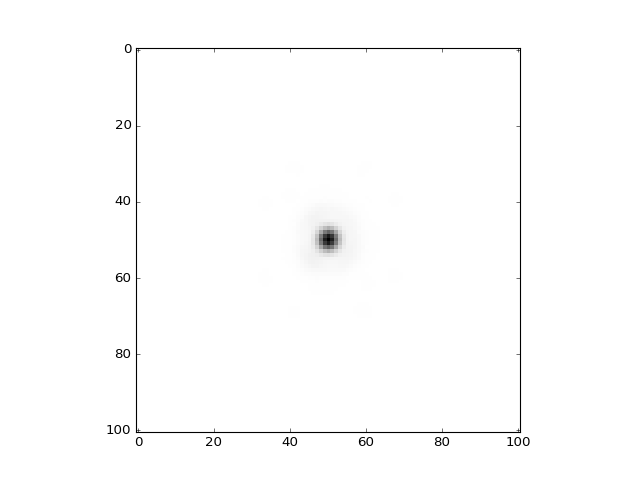

<IPython.core.display.Javascript object>


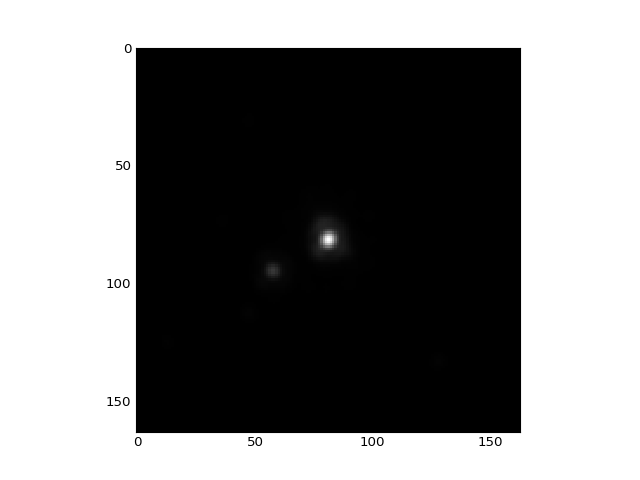

In [92]:
'''

Point spread function (from WFC3 PSFs)
(check out http://www.stsci.edu/hst/wfc3/analysis/PSF for more information)

Noise (from HLS GOODS-S region)
(check out https://archive.stsci.edu/prepds/hlf/ for more information)

It is also important to convect our simulation data and noise data into the same units (by using AB magnitudes)

image_int: (energy flux density for each pixel without noise and PSF)
units [erg/s/cm^2]

'''

pixels_with_noise = fits.open('hlsp_hlf_hst_wfc3-60mas_goodss_f160w_v1.0_sci.fits')[0].data[15000:15000+nbins,10000:10000+nbins]
zero_point = 25.94
coeff = 10 ** (0.4 * (zero_point + 48.6))

image_int *= coeff
image_int += pixels_with_noise


PSF = fits.open('psf_wfc3ir_f160w.fits')[0].data
plt.figure(4)
plt.imshow(PSF, interpolation='nearest',cmap=cm.Greys)
blurred = signal.fftconvolve(image_int, PSF, mode='same')

np.savetxt('f160w_filter.dat',blurred,fmt='%1.5e')

plt.figure(5)
plt.imshow(blurred, interpolation='nearest',cmap=plt.cm.gray)
plt.show()